# Разведывательный анализ данных учащихся

## Цель проекта:
Отследить **влияние условий жизни** учащихся в возрасте от 15 до 22 лет **на их успеваемость по математике**, что позволит на ранней стадии выявлять студентов, находящихся в группе риска.

## Задачи проекта:
1. Провести **разведывательный анализ данных (EDA)**:
    - _проверить качество данных_ и очистить их при необходимости;
    - _сформулировать предположения_ для дальнейшего построения модели;
    - _определиться с параметрами модели_, оказывающими влияние на целевой показатель (успеваемость по математике).
2. Построить модель, предсказывающую результаты госэкзамена по математике для каждого ученика школы.

В рамках данного подпроекта решалась только **первая задача**. 

### Импорт библиотек и модулей, настройка отображения значений

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import math 

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import norm
from random import random

import mod_eda # импортируем модуль с созданными функциями проведения EDA

# Настроим вывод графиков и таблиц
sns.set()

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок

### Функции отображения значений

In [2]:
# Функция отображения состава КАТЕГОРИАЛЬНОЙ КОЛОНКИ
def display_cat_compos(df, column, plot=True, rot=0):
    # Анализ состава колонки
    cat_compos = mod_eda.get_cat_compos(df, column, plot, rot)

    #Вывод состава колонки
    print('\n', cat_compos[0][0])
    display(cat_compos[0][1])
    return cat_compos

In [3]:
# Функция отображения состава ЧИСЛОВОЙ КОЛОНКИ
def display_num_compos(df, column, plot=True):
    # Анализ состава колонки
    num_compos = mod_eda.get_num_compos(df, column, plot)

    # Вывод описательных статистик и выбросов
    print('\n', num_compos[0][0])
    display(num_compos[0][1])
    print('\n', num_compos[1][0])
    if len(num_compos[1][1]) > 0:
        display(num_compos[1][1])
    return num_compos

In [4]:
# Функция отображения ВЗАИМОСВЯЗИ между колонками
def display_col_relation(df, column, sub_column_list, compos=[]):
    if len(compos) > 0:
        #Повторный вывод состава колонки
        print('\n', compos[0][0])
        display(compos[0][1])

    # Оценка взаимосвязи с колонками из списка
    col_relation = mod_eda.find_col_relation(df, column, sub_column_list)

    # Вывод данных по оценке взаимосвязи между колонками
    for i, elem in enumerate(col_relation):
        print('\n')
        print(f'\n{i+1})', elem[0][0])
        display(elem[0][1])
        print('\n', elem[1])
        print('\n', elem[2][0])
        display(elem[2][1])
    
    return col_relation

## Первичный осмотр данных

In [5]:
# Загрузим исходный датасет и рассмотрим его
stud = pd.read_csv('stud_math.csv')
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Первичный осмотр данных позволяет сделать вывод о том, что только *первые 3 колонки без пропусков*: "school", "sex", "age". 

В распоряжении имеются *30* колонок, из них *13* - **условно числовых** (хотя истинно **числовых** только *4*: "age", "absences", "score" и "studytime, granular", остальные **ранговые**), *17* - **категориальных** (*8* из них потенциально можно превратить в бинарный тип).  

Также первичный осмотр данных показал, что часть колонок названы с большой буквы (с целью отделения одного слова от другого). Есть также одна колонка "studytime, granular" имеющая название, написанное через запятую. 

Приведём колонки к стилю написания с маленькой буквы с отделением слов подчёркиванием.

In [6]:
stud.columns = ['school', 'sex', 'age', 'adress', 'famsize', 'p_status', 'm_edu', 'f_edu',
                'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime',
                'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
                'freetime', 'goout', 'health_level', 'absences', 'score']
display(stud.head(10))

,school,sex,age,adress,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### Описание колонок:
1 **school** — аббревиатура школы, в которой учится ученик;

2 **sex** — пол ученика (**'F'** - женский, **'M'** - мужской);

3 **age** — возраст ученика (от **15** до **22**);

4 **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом);

5 **famsize** — размер семьи(**'LE3'** <= 3, **'GT3'** >3);

6 **p_status** — статус совместного жилья родителей (**'T'** - живут вместе **'A'** - раздельно);

7 **m_edu** — образование матери (**0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее);

8 **f_edu** — образование отца (**0** - нет, **1** - 4 класса, **2** - 5-9 классы, 
    **3** - среднее специальное или 11 классов, **4** - высшее);

9 **m_job** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

10 **f_job** — работа отца (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **'services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

11 **reason** — причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое);

12 **guardian** — опекун (**'mother'** - мать, **'father'** - отец, **'other'** - другое);

13 **traveltime** — время в пути до школы (**1** - <15 мин., **2** - 15-30 мин., 
    **3** - 30-60 мин., **4** - >60 мин.);

14 **studytime** — время на учёбу помимо школы в неделю (**1** - <2 часов, **2** - 2-5 часов, 
    **3** - 5-10 часов, **4** - >10 часов);

15 **failures** — количество внеучебных неудач (**n**, если 1<=n<3, иначе **4**);

16 **schoolsup** — дополнительная образовательная поддержка (**yes** или **no**);

17 **famsup** — семейная образовательная поддержка (**yes** или **no**);

18 **paid** — дополнительные платные занятия по математике (**yes** или **no**);

19 **activities** — дополнительные внеучебные занятия (**yes** или **no**);

20 **nursery** — посещал детский сад (**yes** или **no**);

**studytime_granular** - неизвестная колонка, необходимо понять, с чем она коррелирует

21 **higher** — хочет получить высшее образование (**yes** или **no**);

22 **internet** — наличие интернета дома (**yes** или **no**);

23 **romantic** — в романтических отношениях (**yes** или **no**);

24 **famrel** — семейные отношения (от **1** - очень плохо до **5** - очень хорошо);

25 **freetime** — свободное время после школы (от **1** - очень мало до **5** - очень мого);

26 **goout** — проведение времени с друзьями (от **1** - очень мало до **5** - очень много);

27 **health_level** — текущее состояние здоровья (от **1** - очень плохо до **5** - очень хорошо);

28 **absences** — количество пропущенных занятий;

29 **score** — баллы по госэкзамену по математике (целевой параметр).


In [7]:
# ОПРЕДЕЛЕНИЕ РАЗМЕРА ВЫБОРКИ
stud_count_total = len(stud)
print('\nОбщий размер выборки студентов:', stud_count_total)


Общий размер выборки студентов: 395


## Первичный анализ данных в столбцах

### school
Аббревиатура школы, в которой учится ученик.


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки school


,total,proportion
GP,349,0.883544
MS,46,0.116456


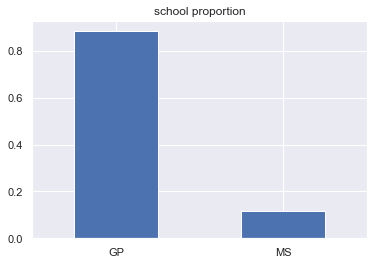

In [8]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'school'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'school'**: Пропуски в данном столбце отсутствуют. Около *88%* студентов выборки (общим размером *395* человек) обучаются в школе **"GP"**.  

### sex
Пол ученика: 'F' - женский, 'M' - мужской


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки sex


,total,proportion
F,208,0.526582
M,187,0.473418


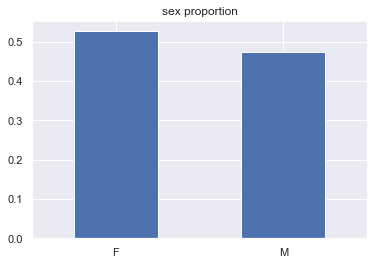

In [9]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'sex'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'sex'**: В данном столбце пропусков нет. Имеется небольшой **перевес**, порядка 5% **в пользу количества девочек** в выборке.

### age
Возраст ученика (от 15 до 22)


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Статистические характеристики колонки age


,age
count,395.000000
mean,16.696203
std,1.276043
min,15.000000
25%,16.000000
50%,17.000000
75%,18.000000
max,22.000000



 Значения выбросов и их количество


,outliers_count
22,1


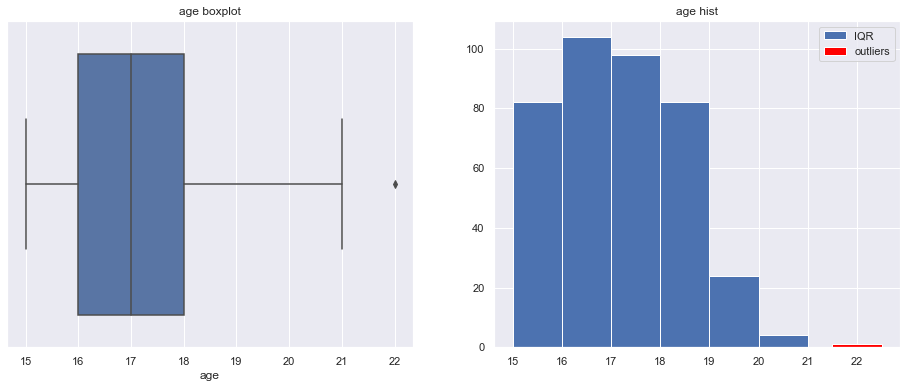

In [10]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ ЧИСЛОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'age'
# Вывод состава колонки
compos = display_num_compos(stud, column)

**Вывод по столбцу 'age'**: В данном столбце отсутствуют пропуски. Возраст студентов имеет близкое к нормальному распределение. Имеется один **выброс - 22 года**

### adress
Тип адреса ученика: **'U'** - городской, **'R'** - за городом.


 17 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 4.3%

 Состав колонки adress


,total,proportion
U,295,0.780423
R,83,0.219577


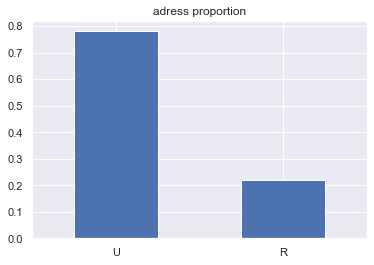

In [11]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'adress'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

### Варианты [заполнения пропусков](https://gallery.azure.ai/Experiment/Methods-for-handling-missing-values-1):
- помещение пропусков в **отдельную группу**, например со значением "0" (*положим, что этот метод актуален при доле пропусков больше **15-20%** *);
- замена пропусков **мерами центра**: модой, медианой, средним и т.д.;
- замена **на соседнее** значение;
- **интерполяция** значений *(актуально для временных рядов)*;
- создание **отдельного столбца с bool-типом** для отслеживания какие 
значения присутствовали в исходном датасете, а какие были искусственно введены.
Применяется при *большом количестве пропусков*;
- учёт уже имеющейся в колонке пропорции между дискретными значениями;
- применение метода **"приписывания"** (*Imputation method*), подразумевающего наличие взаимосвязи значений рассматриваемого столбца с другими, на основе которой можно предположить, какое значение могло быть вместо пропуска. Особенно актуально применение данного метода при наличии корреляции данной колонки
с другой.

Для реализации последних двух методов: **учёта пропорции** в колонке и метода **"приписывания"** была написана функция mod_eda.**fill_rand**(main_series, *sub_series=pd.Series([])*): 
- Если подать на вход в неё только одну колонку, то она заполнит имеющиеся в ней пропуски на основе определённой пропорции между значениями. *Реализовано на генераторе случайных чисел и сопоставлении случайного числа с неравенствами, имеющими тем больший размах, чем больше пропорция для рассматриваемого значения. При попадании случайного числа в определённый интервал, рассматриваемый пропуск заполняется значением, соответствующим этому интервалу*.
- При подаче дополнительной колонки на вход функции, расчёт распределения вероятностей ведётся по теореме [Томаса Байеса](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%B0):
$$p(H_i|A) = \frac{p(H_i)*p(A|H_i)}{p(A)}, $$
где $p(H_i|A)$ - искомая апостериорная вероятность (после опыта) гипотезы $H_i$ при наступлении события $A$;
$p(H_i)$ - априорная вероятность гипотезы (то есть до опыта);
$p(A|H_i)$ - вероятность наступления события $A$ при истинности гипотезы $H_i$;
$p(A)$ - полная вероятность наступления события $A$.

Для начала реализуем метод **"приписывания"** вручную, а затем сопоставим результат с работой написанной функции.
Найдём ту колонку, которая, исходя из логических соображений, может коррелировать с рассматриваемой. Для числовых колонок можно находить корреляцию посредством функции **.corr()**, применяемой к датафрейму.

Найдём колонку, наиболее сильно коррелирующую с колонкой **'adress'**

In [12]:
temp = stud.copy(deep=True) # Копирование датафрейма без зависимости
# Временно, для грубой оценки зависимости, приведём столбец "adress" к числовому виду
temp['adress'] = temp['adress'].apply(lambda x: 1 if str(x) == 'U' else 0 if str(x) == 'R' else None)
temp.corr()['adress']

age                  -0.147902
adress                1.000000
m_edu                 0.153189
f_edu                 0.065295
traveltime           -0.285782
studytime            -0.045182
failures             -0.101835
studytime_granular    0.045182
famrel               -0.017216
freetime              0.055708
goout                 0.063285
health_level         -0.049985
absences              0.025661
score                 0.120067
Name: adress, dtype: float64

Анализ показал, что предположительно имеется связь между **"adress" и "traveltime"** (типом адреса ученика и временем, затрачиваемым на дорогу). **Предполагается**, что при большом времени в пути ученик живёт за городом.

Проверим статистическую значимость взаимосвязи этих колонок.

#### Для решения этой задачи была написана функция нахождения колонок, имеющих статистически значимую взаимосвязь с изучаемой
**Идея:** найти те колонки, в которых расхождение в распределении значений по параметрам исследуемой колонки имеет статистическую значимость.

Данная идея была реализована посредством написанной функции mod_eda.**get_col_depend**(...)

In [13]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

adress ~ school              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 6.952
adress ~ age                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 3.29
adress ~ m_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.589
adress ~ m_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.121
adress ~ reason              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.729
adress ~ traveltime          	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 5.242
adress ~ studytime           	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.041
adress ~ failures            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.857
adress ~ studytime_granular  	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.041
adress ~ internet            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 3.31
ad

,rel_amount,col_name,log_frac
0,1.000,school,6.952
2,2.000,traveltime,5.242
4,0.222,score,3.335
3,1.000,internet,3.31
1,0.750,age,3.29


Тестирование гипотез о разности выборочных пропорций показало, что есть статистически значимая взаимосвязь между "adress" и "school", "traveltime", "score", "internet", "age"

In [14]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['school', 'traveltime']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки adress


,total,proportion
U,295,0.780423
R,83,0.219577





1) Распределение значений колонки school по значениям изучаемой колонки adress


school,GP,MS
adress,,
R,0.178042,0.560976
U,0.821958,0.439024



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки adress по значениям колонки school


,school
GP,0.705882
MS,0.294118





2) Распределение значений колонки traveltime по значениям изучаемой колонки adress


traveltime,1.0,2.0,3.0,4.0
adress,,,,
R,0.145299,0.285714,0.571429,0.571429
U,0.854701,0.714286,0.428571,0.428571



 Количество строк с пропусками в обеих колонках: 3

 Состав для None-значений изучаемой колонки adress по значениям колонки traveltime


,traveltime
1.0,0.571429
2.0,0.357143
3.0,0.071429


Заполним пропуски функцией mod_eda.**fill_rand**.


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки adress


,total,proportion
U,305,0.772152
R,90,0.227848


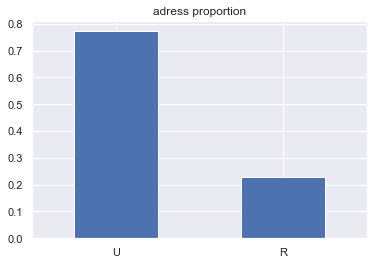

In [15]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'school'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Заполнение функцией mod_eda.**fill_rand** дало пропорцию между значениями более близкую к изначальной c расхождением в 1%.

**Вывод по столбцу 'adress'**: Таким образом, **17** пропущенных значений колонки **adress** были заполнены методом **приписывания**, то есть с учётом данных в других колонках. Наиболее ярко выраженная статистически значимая связь между **"school"** и **"adress"**, **"traveltime"**, **"score"**

Около 78% учеников **живёт в городе**.

### famsize
Размер семьи: 'LE3' <= 3, 'GT3' >3


 27 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 6.8%

 Состав колонки famsize


,total,proportion
GT3,261,0.709239
LE3,107,0.290761


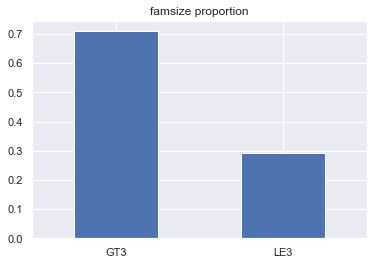

In [16]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'famsize'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Найдём колонки со статистически значимой взаимосвязью.

In [17]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

famsize ~ sex                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.548
famsize ~ p_status            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.113
famsize ~ studytime           	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.295
famsize ~ famsup              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.907
famsize ~ paid                	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.187
famsize ~ nursery             	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.593
famsize ~ studytime_granular  	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.295

Колонки с наиболее сильной взаимосвязью


,rel_amount,col_name,log_frac
1,1.5,studytime,2.295
4,1.5,studytime_granular,2.295
2,1.0,famsup,0.907
3,1.0,nursery,0.593
0,1.0,sex,0.548


Рассмотрим взаимосвязь "studytime" и "famsize", имеющую наибольшее отношение alpha/p_value.

In [19]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['studytime', 'famsup']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки famsize


,total,proportion
GT3,261,0.709239
LE3,107,0.290761





1) Распределение значений колонки studytime по значениям изучаемой колонки famsize


studytime,1.0,2.0,3.0,4.0
famsize,,,,
GT3,0.684211,0.662983,0.883333,0.692308
LE3,0.315789,0.337017,0.116667,0.307692



 Количество строк с пропусками в обеих колонках: 1

 Состав для None-значений изучаемой колонки famsize по значениям колонки studytime


,studytime
2.0,0.500000
1.0,0.307692
3.0,0.153846
4.0,0.038462





2) Распределение значений колонки famsup по значениям изучаемой колонки famsize


famsup,no,yes
famsize,,
GT3,0.645669,0.759615
LE3,0.354331,0.240385



 Количество строк с пропусками в обеих колонках: 6

 Состав для None-значений изучаемой колонки famsize по значениям колонки famsup


,famsup
yes,0.52381
no,0.47619


Ввиду того, что количество строк с пропусками в обеих колонках меньше в первом варианте, а также alpha/p_value максимально, заполним с помощью колонки **'studytime'**


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки famsize


,total,proportion
GT3,279,0.706329
LE3,116,0.293671


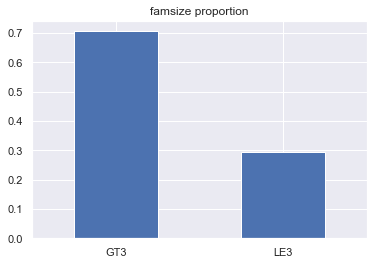

In [20]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'studytime'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'famsize'**: **27** пропущенных значений колонки **famsize** были заполнены методом **приписывания**. Наиболее сильная статистически значимая связь между **"studytime"** и **"famsize"**.

Около 70% учеников живёт в семье с размером семьи **больше 3х человек**.

### **p_status**
Cтатус совместного жилья родителей: **'T'** - живут вместе, **'A'** - раздельно.


 45 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 11.4%

 Состав колонки p_status


,total,proportion
T,314,0.897143
A,36,0.102857


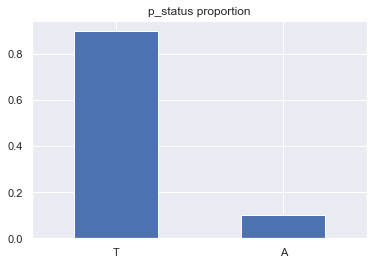

In [21]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'p_status'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Найдём колонки со статистически значимой связью.

In [24]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

p_status ~ school              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.046
p_status ~ age                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.607
p_status ~ famsize             	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.436
p_status ~ m_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.445
p_status ~ activities          	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.56

Колонки с наиболее сильной взаимосвязью


,rel_amount,col_name,log_frac
1,0.375,age,2.607
3,0.400,m_edu,1.445
4,1.000,activities,0.56
2,1.000,famsize,0.436
0,0.500,school,0.046


Рассмотрим взаимосвязь "m_edu", "activities" и "p_status".

In [25]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_edu', 'activities']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки p_status


,total,proportion
T,314,0.897143
A,36,0.102857





1) Распределение значений колонки m_edu по значениям изучаемой колонки p_status


m_edu,0.0,1.0,2.0,3.0,4.0
p_status,,,,,
A,0.0,0.019231,0.066667,0.168675,0.123967
T,1.0,0.980769,0.933333,0.831325,0.876033



 Количество строк с пропусками в обеих колонках: 2

 Состав для None-значений изучаемой колонки p_status по значениям колонки m_edu


,m_edu
3.0,0.325581
2.0,0.279070
4.0,0.232558
1.0,0.162791





2) Распределение значений колонки activities по значениям изучаемой колонки p_status


activities,no,yes
p_status,,
A,0.13253,0.069767
T,0.86747,0.930233



 Количество строк с пропусками в обеих колонках: 2

 Состав для None-значений изучаемой колонки p_status по значениям колонки activities


,activities
yes,0.534884
no,0.465116


Для заполнения пропусков воспользуемся наиболее сильно связанной с изучаемой колонкой - "m_edu".
"age" даёт статистическую связь ввиду наличия выбросов


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки p_status


,total,proportion
T,357,0.903797
A,38,0.096203


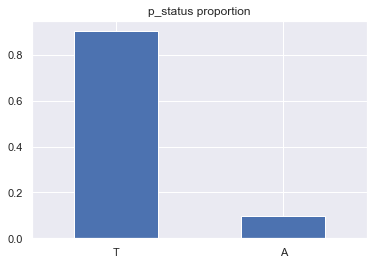

In [26]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'p_status'**: **45** пропущенных значений колонки **p_status** были заполнены методом **приписывания**. Наиболее сильная статистически значимая связь между **"age"**, **"m_edu"** и **"p_status"**.

Около 90% учеников живёт в семье с родителями, живущими **вместе**.

### m_edu
Образование матери: **0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее


 3 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 0.8%

 Состав колонки m_edu


,total,proportion
4.0,131,0.334184
2.0,102,0.260204
3.0,97,0.247449
1.0,59,0.150510
0.0,3,0.007653


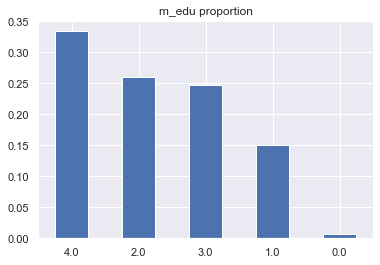

In [27]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'm_edu'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [28]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

m_edu ~ school              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 4.312
m_edu ~ sex                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.401
m_edu ~ age                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.818
m_edu ~ adress              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.286
m_edu ~ famsize             	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.138
m_edu ~ p_status            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.462
m_edu ~ f_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 7.694
m_edu ~ m_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 9.566
m_edu ~ f_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 8.889
m_edu ~ guardian            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.603
m_edu ~ tr

,rel_amount,col_name,log_frac
2,3.8,m_job,9.566
3,1.4,f_job,8.889
1,1.0,f_edu,7.694
0,1.5,school,4.312
4,0.5,failures,3.28


Так как пропущенных значений всего 3, заполним пропуски вручную.

In [29]:
stud[stud[column].isna()]

,school,sex,age,adress,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score
92,GP,F,16,U,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
193,GP,M,16,R,GT3,T,NaN,3.0,services,services,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
239,GP,M,18,U,GT3,T,NaN,2.0,other,services,reputation,father,1.0,2.0,1.0,no,no,no,no,yes,-6.0,no,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0


In [31]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_job', 'f_job']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки m_edu


,total,proportion
4.0,131,0.334184
2.0,102,0.260204
3.0,97,0.247449
1.0,59,0.150510
0.0,3,0.007653





1) Распределение значений колонки m_job по значениям изучаемой колонки m_edu


m_job,at_home,health,other,services,teacher
m_edu,,,,,
0.0,0.034483,0.00000,0.007634,0.000000,0.000000
1.0,0.431034,0.03125,0.198473,0.051546,0.000000
2.0,0.362069,0.06250,0.343511,0.309278,0.000000
3.0,0.137931,0.15625,0.282443,0.391753,0.054545
4.0,0.034483,0.75000,0.167939,0.247423,0.945455



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки m_edu по значениям колонки m_job


,m_job
other,0.666667
services,0.333333





2) Распределение значений колонки f_job по значениям изучаемой колонки m_edu


f_job,at_home,health,other,services,teacher
m_edu,,,,,
0.0,0.0625,0.000000,0.010204,0.00,0.000000
1.0,0.2500,0.066667,0.147959,0.19,0.034483
2.0,0.3750,0.266667,0.295918,0.25,0.034483
3.0,0.0625,0.200000,0.280612,0.26,0.068966
4.0,0.2500,0.466667,0.265306,0.30,0.862069



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки m_edu по значениям колонки f_job


,f_job
services,0.666667
other,0.333333


На основе анализа колонки 'm_job' было принято решения заполнить пропуски следующим образом:

In [32]:
def fillna_m_edu(row):
    if pd.isna(row['m_edu']):
        if row['m_job'] == 'other':
            return 2
        else:
            return 3
    return row['m_edu']


stud[column] = stud.apply(fillna_m_edu, axis=1)


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки m_edu


,total,proportion
4,131,0.331646
2,104,0.263291
3,98,0.248101
1,59,0.149367
0,3,0.007595


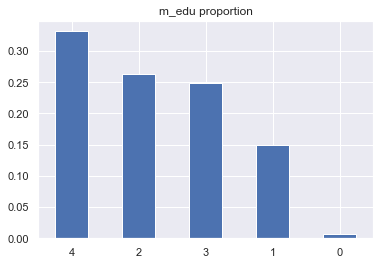

In [33]:
# После заполнения Nan превратим колонку в int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'm_edu'**: **3** пропущенных значений колонки были заполнены вручную на основе данных колонки **"f_job"**. Наиболее сильная статистически значимая связь между **'m_edu'** и **"m_job"**, **"f_job"**, **"f_edu"**.

Наибольшее количество матерей с **высшим** образованием

### f_edu
Образование отца: **0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее

In [35]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'f_edu'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)


 24 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 6.1%

 Состав колонки f_edu


,total,proportion
2.0,106,0.285714
3.0,96,0.258760
4.0,88,0.237197
1.0,78,0.210243
0.0,2,0.005391
40.0,1,0.002695


Имеется значение несоответствующее заявленным категориям. Логично предположить, что это значение "4" с опечаткой, исправим его.


 24 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 6.1%

 Состав колонки f_edu


,total,proportion
2.0,106,0.285714
3.0,96,0.258760
4.0,89,0.239892
1.0,78,0.210243
0.0,2,0.005391


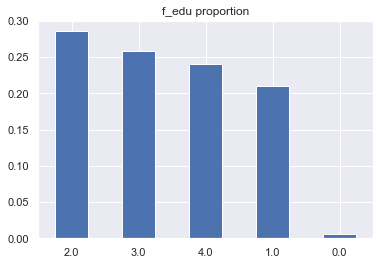

In [36]:
stud['f_edu'] = stud['f_edu'].replace(40, 4)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

Найдём взаимосвязанные колонки

In [37]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

f_edu ~ school              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.93
f_edu ~ age                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.434
f_edu ~ adress              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.75
f_edu ~ famsize             	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.007
f_edu ~ p_status            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.686
f_edu ~ m_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = inf
f_edu ~ m_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 5.791
f_edu ~ f_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 6.173
f_edu ~ guardian            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.901
f_edu ~ traveltime          	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.691
f_edu ~ failur

,rel_amount,col_name,log_frac
0,3.8,m_edu,inf
4,1.0,failures,8.026
2,2.0,f_job,6.173
1,2.6,m_job,5.791
3,0.5,traveltime,2.691


Проанализируем взаимосвязь колонок "m_edu", "failures", "f_job"  и "f_edu"

In [38]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_edu', 'failures', 'f_job']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки f_edu


,total,proportion
2.0,106,0.285714
3.0,96,0.258760
4.0,89,0.239892
1.0,78,0.210243
0.0,2,0.005391





1) Распределение значений колонки m_edu по значениям изучаемой колонки f_edu


m_edu,0,1,2,3,4
f_edu,,,,,
0.0,0.000000,0.017857,0.00,0.000000,0.008264
1.0,0.333333,0.642857,0.28,0.142857,0.000000
2.0,0.666667,0.232143,0.48,0.274725,0.148760
3.0,0.000000,0.089286,0.17,0.384615,0.322314
4.0,0.000000,0.017857,0.07,0.197802,0.520661



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки f_edu по значениям колонки m_edu


,m_edu
4,0.416667
3,0.291667
2,0.166667
1,0.125000





2) Распределение значений колонки failures по значениям изучаемой колонки f_edu


failures,0.0,1.0,2.0,3.0
f_edu,,,,
0.0,0.003597,0.000000,0.000000,0.000000
1.0,0.165468,0.355556,0.214286,0.800000
2.0,0.284173,0.288889,0.428571,0.133333
3.0,0.276978,0.200000,0.214286,0.066667
4.0,0.269784,0.155556,0.142857,0.000000



 Количество строк с пропусками в обеих колонках: 3

 Состав для None-значений изучаемой колонки f_edu по значениям колонки failures


,failures
0.0,0.714286
1.0,0.190476
2.0,0.095238





3) Распределение значений колонки f_job по значениям изучаемой колонки f_edu


f_job,at_home,health,other,services,teacher
f_edu,,,,,
0.0,0.000000,0.000000,0.010526,0.000000,0.000000
1.0,0.214286,0.076923,0.252632,0.202128,0.000000
2.0,0.428571,0.076923,0.305263,0.287234,0.000000
3.0,0.214286,0.230769,0.268421,0.329787,0.038462
4.0,0.142857,0.615385,0.163158,0.180851,0.961538



 Количество строк с пропусками в обеих колонках: 2

 Состав для None-значений изучаемой колонки f_edu по значениям колонки f_job


,f_job
services,0.363636
other,0.318182
teacher,0.136364
health,0.090909
at_home,0.090909


Воспользуемся колонкой "m_edu" для заполнения пропусков


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки f_edu


,total,proportion
2,114,0.288608
3,103,0.260759
4,95,0.240506
1,81,0.205063
0,2,0.005063


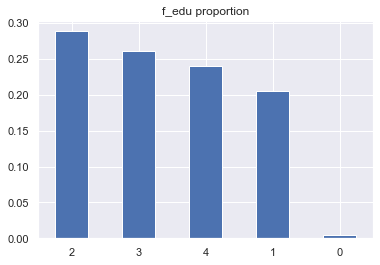

In [40]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# После заполнения Nan превратим колонку в int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'f_edu'**: **24** пропущенных значений колонки были заполнены методом **приписывания**. Наиболее сильная статистически значимая связь между **"f_edu"** и **"m_edu"**, **"failures"**, **"f_job"**.

Наибольшее количество отцов с образованием **5-9 классы**.

### m_job
Работа матери: **'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое.


 19 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 4.8%

 Состав колонки m_job


,total,proportion
other,133,0.353723
services,98,0.260638
at_home,58,0.154255
teacher,55,0.146277
health,32,0.085106


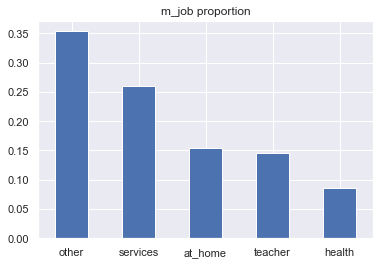

In [41]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'm_job'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [42]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

m_job ~ sex                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.236
m_job ~ adress              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.736
m_job ~ famsize             	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.159
m_job ~ m_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 9.038
m_job ~ f_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 4.823
m_job ~ f_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 4.112
m_job ~ reason              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.457
m_job ~ guardian            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.093
m_job ~ traveltime          	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.011
m_job ~ famsup              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.016
m_job ~ pa

,rel_amount,col_name,log_frac
1,2.8,m_edu,9.038
2,2.2,f_edu,4.823
3,1.2,f_job,4.112
4,0.5,internet,2.858
0,1.0,sex,2.236


Проанализируем связь с образованием матери.

In [43]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_edu']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки m_job


,total,proportion
other,133,0.353723
services,98,0.260638
at_home,58,0.154255
teacher,55,0.146277
health,32,0.085106





1) Распределение значений колонки m_edu по значениям изучаемой колонки m_job


m_edu,0,1,2,3,4
m_job,,,,,
at_home,0.666667,0.438596,0.21,0.086957,0.016129
health,0.000000,0.017544,0.02,0.054348,0.193548
other,0.333333,0.456140,0.47,0.402174,0.177419
services,0.000000,0.087719,0.30,0.423913,0.193548
teacher,0.000000,0.000000,0.00,0.032609,0.419355



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки m_job по значениям колонки m_edu


,m_edu
4,0.368421
3,0.315789
2,0.210526
1,0.105263



 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки m_job


,total,proportion
other,139,0.351899
services,104,0.263291
at_home,59,0.149367
teacher,58,0.146835
health,35,0.088608


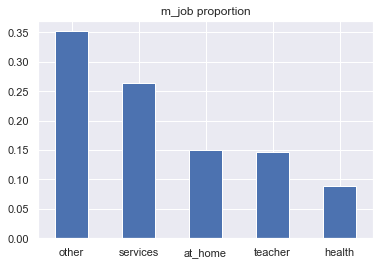

In [44]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'm_job'**: **19** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь между **"m_job"** и **"m_edu"**, **"f_edu"**, **"f_job"**.

Наибольшее количество матерей работает (помимо варианта **"другое"**) **на гос. службе**.

### f_job
Работа отца: **'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое.


 36 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 9.1%

 Состав колонки f_job


,total,proportion
other,197,0.548747
services,102,0.284123
teacher,29,0.080780
at_home,16,0.044568
health,15,0.041783


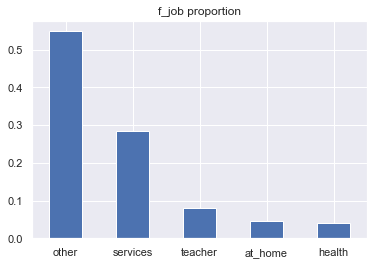

In [45]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'f_job'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [46]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

f_job ~ school              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.466
f_job ~ m_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.356
f_job ~ f_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.861
f_job ~ m_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 5.832
f_job ~ guardian            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.136
f_job ~ famsup              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.304
f_job ~ activities          	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.234
f_job ~ nursery             	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.198
f_job ~ higher              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.756
f_job ~ internet            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.313

Колонки с

,rel_amount,col_name,log_frac
3,1.0,m_job,5.832
2,0.6,f_edu,2.861
4,1.0,guardian,2.136
0,1.0,school,1.466
1,0.4,m_edu,1.356


Проанализируем связь с работой матери

In [48]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_job', 'f_edu']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки f_job


,total,proportion
other,197,0.548747
services,102,0.284123
teacher,29,0.080780
at_home,16,0.044568
health,15,0.041783





1) Распределение значений колонки m_job по значениям изучаемой колонки f_job


m_job,at_home,health,other,services,teacher
f_job,,,,,
at_home,0.094340,0.000000,0.039062,0.042553,0.036364
health,0.037736,0.103448,0.015625,0.042553,0.072727
other,0.566038,0.586207,0.726562,0.382979,0.381818
services,0.264151,0.275862,0.171875,0.436170,0.309091
teacher,0.037736,0.034483,0.046875,0.095745,0.200000



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки f_job по значениям колонки m_job


,m_job
other,0.305556
services,0.277778
health,0.166667
at_home,0.166667
teacher,0.083333





2) Распределение значений колонки f_edu по значениям изучаемой колонки f_job


f_edu,0,1,2,3,4
f_job,,,,,
at_home,0.0,0.054795,0.060606,0.041667,0.022472
health,0.0,0.013699,0.010101,0.041667,0.101124
other,1.0,0.657534,0.636364,0.531250,0.370787
services,0.0,0.273973,0.292929,0.375000,0.191011
teacher,0.0,0.000000,0.000000,0.010417,0.314607



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки f_job по значениям колонки f_edu


,f_edu
2,0.416667
1,0.222222
3,0.194444
4,0.166667


Проанализируем связь с образованием отца

Остановимся на связи с работой матери, как наиболее сильно связанной колонке с работой отца


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки f_job


,total,proportion
other,222,0.562025
services,110,0.278481
teacher,30,0.075949
health,17,0.043038
at_home,16,0.040506


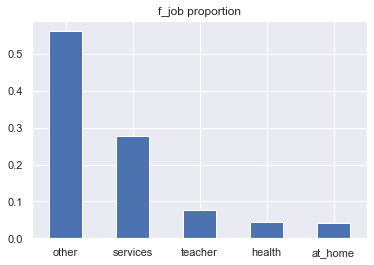

In [49]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_job'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'f_job'**: **36** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_job"**. Наиболее сильная статистически значимая связь между **"f_job"** и **"m_job"**, **"f_edu"** и **"guardian"**.

Наибольшее количество отцов также работает (помимо варианта **"другое"**) **на гос. службе**.

### reason
Причина выбора школы: **'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое.


 17 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 4.3%

 Состав колонки reason


,total,proportion
course,137,0.362434
home,104,0.275132
reputation,103,0.272487
other,34,0.089947


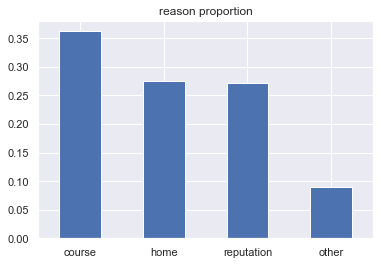

In [50]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'reason'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [51]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

reason ~ school              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.852
reason ~ sex                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.856
reason ~ adress              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.656
reason ~ m_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.451
reason ~ f_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.084
reason ~ guardian            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.137
reason ~ studytime           	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 4.623
reason ~ failures            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.511
reason ~ famsup              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.775
reason ~ paid                	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.347


,rel_amount,col_name,log_frac
3,1.5,studytime,4.623
4,1.5,studytime_granular,4.623
2,0.6,m_job,2.451
0,0.5,school,1.852
1,0.5,adress,1.656


Проанализируем связь с временем на учёбу и адресом проживания

In [52]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['studytime', 'adress']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки reason


,total,proportion
course,137,0.362434
home,104,0.275132
reputation,103,0.272487
other,34,0.089947





1) Распределение значений колонки studytime по значениям изучаемой колонки reason


studytime,1.0,2.0,3.0,4.0
reason,,,,
course,0.453608,0.322751,0.393443,0.28
home,0.268041,0.312169,0.229508,0.16
other,0.144330,0.068783,0.098361,0.00
reputation,0.134021,0.296296,0.278689,0.56



 Количество строк с пропусками в обеих колонках: 1

 Состав для None-значений изучаемой колонки reason по значениям колонки studytime


,studytime
1.0,0.3750
2.0,0.3125
3.0,0.1875
4.0,0.1250





2) Распределение значений колонки adress по значениям изучаемой колонки reason


adress,R,U
reason,,
course,0.404494,0.349481
home,0.157303,0.311419
other,0.123596,0.079585
reputation,0.314607,0.259516



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки reason по значениям колонки adress


,adress
U,0.941176
R,0.058824


Заполним пропуски в соответствии со значениями колонки "studytime" (больше вариаций значений для None-колонки)


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки reason


,total,proportion
course,146,0.369620
reputation,108,0.273418
home,106,0.268354
other,35,0.088608


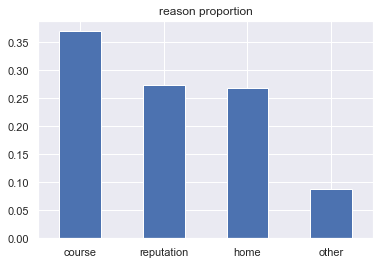

In [53]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'studytime'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'reason'**: **17** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"studytime"**. Наиболее сильная статистически значимая связь между **"reason"** и **"studytime"**, **"adress"**.

Наибольшее количество причин выбора школы связаны с **образовательной программой**.

### guardian
Опекун: **'mother'** - мать, **'father'** - отец, **'other'** - другое.
По всей видимости здесь имеется в виду, кто из родителей (или не из родителей в случае "other") является наиболее сильно заботящимся о ребёнке


 31 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 7.8%

 Состав колонки guardian


,total,proportion
mother,250,0.686813
father,86,0.236264
other,28,0.076923


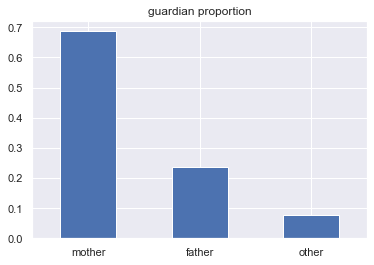

In [54]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'guardian'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [55]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col[0])

guardian ~ sex                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.294
guardian ~ age                 	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 6.07
guardian ~ adress              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.491
guardian ~ m_edu               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.852
guardian ~ m_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.126
guardian ~ f_job               	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.776
guardian ~ reason              	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 1.165
guardian ~ studytime           	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 0.882
guardian ~ failures            	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/p_value) = 2.2
guardian ~ paid                	ОБНАРУЖЕНА статистически значимая связь		log10(alpha/

,rel_amount,col_name,log_frac
0,0.571,age,6.07
4,1.000,health_level,2.619
3,1.000,nursery,2.35
2,0.500,failures,2.2
1,0.800,m_job,2.126


Рассмотрим взаимосвязь с колонками "age" и "health_level"

In [56]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['age', 'health_level']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


 Состав колонки guardian


,total,proportion
mother,250,0.686813
father,86,0.236264
other,28,0.076923





1) Распределение значений колонки age по значениям изучаемой колонки guardian


age,15,16,17,18,19,20,22
guardian,,,,,,,
father,0.298701,0.237113,0.241758,0.219178,0.083333,0.0,0.0
mother,0.675325,0.742268,0.747253,0.726027,0.166667,0.0,1.0
other,0.025974,0.020619,0.010989,0.054795,0.750000,1.0,0.0



 Количество строк с пропусками в обеих колонках: 0

 Состав для None-значений изучаемой колонки guardian по значениям колонки age


,age
18,0.290323
17,0.225806
16,0.225806
15,0.161290
20,0.064516
21,0.032258





2) Распределение значений колонки health_level по значениям изучаемой колонки guardian


health_level,1.0,2.0,3.0,4.0,5.0
guardian,,,,,
father,0.111111,0.333333,0.202532,0.228070,0.267717
mother,0.866667,0.523810,0.645570,0.736842,0.677165
other,0.022222,0.142857,0.151899,0.035088,0.055118



 Количество строк с пропусками в обеих колонках: 1

 Состав для None-значений изучаемой колонки guardian по значениям колонки health_level


,health_level
5.0,0.366667
3.0,0.333333
4.0,0.200000
1.0,0.066667
2.0,0.033333


Для заполнения пропусков была выбрана колонка **health_level**, так как в первой колонке наиболее сильная диспропорция в значении параметра "опекун" связана со значениями выброса и близкими к нему, в остальных колонках пропорция остаётся схожей.


 None-значения отсутствуют. Пробельные пропуски отсутствуют.

 Состав колонки guardian


,total,proportion
mother,269,0.681013
father,97,0.245570
other,29,0.073418


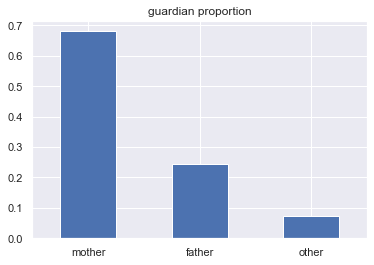

In [57]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'health_level'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'guardian'**: **31** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"health_level"**. Наиболее сильная статистически значимая связь между **"guardian"** и **"age"**, **"health_level"**, **"nursery"**, **"failures"**.

Наибольшее количество опекунов - **матери**.